# Description
Open scraped json data and do EDA.
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.
# Imports

In [34]:
# data wrangling
import json
import re
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import os.path
from datetime import timedelta

# viz
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
import statsmodels.graphics as smg

In [2]:
def mask(df, col, value):
    """low-overhead method similar to .query()"""
    return df[df[col] == value]
pd.DataFrame.mask = mask

# Parameters

In [55]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('Solarize_Light2')

In [4]:
data_path = r'../../data/ots_snowfall_data.json'

# Load Data

In [5]:
with open(data_path, 'r') as json_file:
    json_file_read = json_file.read()
    json_file_clean = json.loads(json_file_read)
    raw_df = pd.DataFrame(json_file_clean)
raw_df.tail()

station what_data  year  \
5431     Bruce Mound      base  2018   
5432  Sleeping Giant      base  2018   
5433    Elko SnoBowl      base  2018   
5434     Eagle Point      base  2018   
5435       Pine Knob      base  2018   

                                                    url  \
5431  https://www.onthesnow.com/wisconsin/bruce-moun...   
5432  https://www.onthesnow.com/wyoming/sleeping-gia...   
5433  https://www.onthesnow.com/nevada/elko-snobowl/...   
5434  https://www.onthesnow.com/utah/eagle-point/his...   
5435  https://www.onthesnow.com/michigan/pine-knob-s...   

                                                   data  
5431  {'Dec 2018': {'15': 12, '16': 12, '17': 12, '1...  
5432  {'Dec 2018': {'14': 30, '15': 28, '16': 26, '1...  
5433                                                 {}  
5434  {'Dec 2018': {'28': 28, '29': 28, '30': 28, '3...  
5435  {'Nov 2018': {'30': 24}, 'Dec 2018': {'1': 24,...

In [6]:
def data_exploder(df, station):
    """create dataframe of station data in tabular form
    todo: make more efficient for loading all data at once"""

    def cleaner(df, data_pt):
        """pull data out of json into columns
        data_pt is base or snowfall"""
        return (pd.json_normalize(df.loc[df.what_data == data_pt, 'data'])
                    .sum()
                    .T.to_frame()
                    .rename(columns={0: data_pt}))

    station_df = (df.query('station == @station')[['data', 'what_data', 'url']])
    
    base_df = cleaner(station_df, 'base')
    snowfall_df = cleaner(station_df, 'snowfall')
    station_data_df = pd.concat([base_df, snowfall_df], axis=1)
    state_rx = r"(?<=^https:\/\/www.onthesnow.com\/)([\w-]*)(?=\/)"
    #print(type(station_df.url.str.extract(state_rx, expand=False)))
    station_data_df['state'] = station_df.url.str.extract(state_rx, expand=False).iloc[0]
    
    station_data_df['station'] = station
    
    dt_format = "%b %Y.%d"
    station_data_df.index = pd.to_datetime(station_data_df.index, format=dt_format)
    return station_data_df

In [7]:
def annualizer(df):
    """grounds and aggregates by day of year"""
    df.index.name = 'timestamp'

    def day_standardizer(day):
        """moves start of year forward so ski season isn't split"""
        rewind = 130  # days before 12/31 to start ski season
        return np.mod((day+rewind), 366)
    df_by_yr = (df
                .reset_index()
                .assign(year=lambda x: x.timestamp.dt.year)
                .assign(month=lambda x: x.timestamp.dt.month)
                .assign(day=lambda x: x.timestamp.dt.day)
                .assign(dayofyr=lambda x: 
                        day_standardizer(x.timestamp.dt.dayofyear))
                .assign(ski_yr=lambda x: (x.dayofyr/365 + (x.year - 2010)).astype('int'))
                .reset_index()
                .filter(['dayofyr', 'timestamp', 'base', 
                         'station', 'snowfall', 'ski_yr',
                         'state', ])
                )
    return df_by_yr

In [14]:
# pickle data after long processing
all_data_path = r"../../data/all_snow_data_df.pkl"
if os.path.exists(all_data_path):
    all_data_full_df = pd.read_pickle(all_data_path)
else:
    all_data_df = pd.concat([data_exploder(raw_df, x) for x in raw_df.station.unique()])
    all_data_full_df = all_data_df.pipe(annualizer)
    all_data_full_df.to_pickle(all_data_path)

### Modeling regions as single series
Concat all base ts from a region into single long series

In [15]:
region_map = {'East': ['New_York', 'Vermont', 'Pennsylvania', 'West_Virginia'],
              'Colorado': ['Colorado'],
              'Utah': ['Utah'],
              'Sierras': ['California', 'Nevada'],
              'Cascades': ['Washington', 'Oregon', 'British_Columbia'],
              'Other': ['Alabama', 'Alaska', 'Alberta', 'Arizona',
                        'Connecticut', 'Idaho', 'Illinois',
                        'Indiana', 'Iowa', 'Maine', 'Maryland', 
                        'Massachusetts',
                        'Michigan', 'Minnesota', 'Missouri', 'Montana',
                        'New Hampshire', 'New Jersey', 'New Mexico',
                        'Newfoundland_and_Labrador', 'North_Carolina', 
                        'North_Dakota', 'Nova Scotia', 'Ohio', 'Ontario',
                        'Quebec', 'Rhode_Island', 'South_Dakota', 'Tennessee',
                        'Virginia', 'Wisconsin',
                        'Wyoming']
              }
region_reverse_map = {}
for region, states in region_map.items():
    for state in states:
        region_reverse_map.update({state.lower(): region})

In [16]:
all_data_full_df = (all_data_full_df
                    .assign(region=lambda x: x.state.map(region_reverse_map)))
all_data_full_df.head()

dayofyr  timestamp  base           station  snowfall  ski_yr    state  \
0      100 2010-12-02  36.0  Showdown Montana       NaN       0  montana   
1      101 2010-12-03  36.0  Showdown Montana       NaN       0  montana   
2      102 2010-12-04  38.0  Showdown Montana       6.0       0  montana   
3      103 2010-12-05  38.0  Showdown Montana       NaN       0  montana   
4      105 2010-12-07  42.0  Showdown Montana       NaN       0  montana   

  region  
0  Other  
1  Other  
2  Other  
3  Other  
4  Other

### Outliers
There are some values where the base jumps by hundreds of inches or more. I will replace outliers with prior base depth.

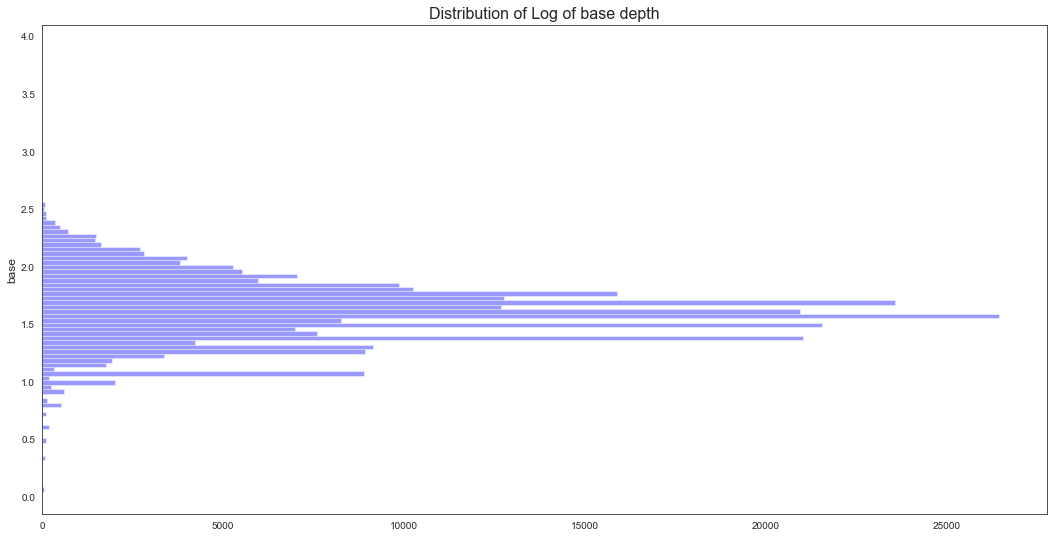

In [17]:
sns.set_style('white')
plt.figure(figsize=(18, 9))
g = sns.distplot(np.log10(all_data_full_df.base + .1), 
                 vertical=True, kde=False, bins=100, color='b')
plt.title('Distribution of Log of base depth');

The log transformed base depth looks relatively normal. I will windsorize data larger than 3 std dev. I will only change the right tail.

In [18]:
log10_base = np.log10(all_data_full_df.base + .1)
log_mean = log10_base.mean()
log_std = log10_base.std()
log_base_cutoff = log_mean + 3*log_std
base_cutoff = 10**log_base_cutoff

In [19]:
print(f"The cutoff is {round(np.log10(258), 3)} on the log chart above, or {round(base_cutoff, 3)} inches of snow.")

The cutoff is 2.412 on the log chart above, or 258.45 inches of snow.


In [20]:
def outlier_remover(df, col, limit):
    """replaces values in col (base or snowfall) with prior values
    NaNs in backup col"""
    df["old_col"] = df[col]
    if col == "base":
        # backup NaNs
        df['nan_locs'] = np.where(df[col].isna(), True, False)
        # fill overlimits with backvalues
        df[col] = np.where((df[col]>limit), np.NaN, df[col])
        df[col] = df[col].fillna(method='ffill', axis=0)
        # return NaNs to column
        df.loc[df.nan_locs, col] = np.NaN
    elif col == "snowfall":
        df[col] = np.where(df[col]>limit, 0, df[col])
    df = df.drop(columns=['old_col'])
    return df
all_data_full_df = all_data_full_df.pipe(outlier_remover, col='base', 
                                         limit=base_cutoff)

In [21]:
def station_ranker(gbdf):
    """takes groupby df and groups by station and returns with columns"""
    stations = gbdf.station.unique()
    station_rank = {station: rank for rank, station in enumerate(stations)}
    return station_rank

ranks = (all_data_full_df.groupby(['region'])[['station', 'region']]
         .apply(station_ranker)
         .to_frame().rename(columns={0: 'data'})
         )

offsets_df = pd.concat(
        [pd.DataFrame.from_dict(ranks[ranks.index == index].values[0][0],
                                orient='index').rename(columns={0: 'offset'})
         for index in ranks.index], axis=0)

In [22]:
dayspyr = 365
long_series_df = (all_data_full_df
                  .sort_values(by=['state', 'station', 'timestamp'], 
                               ascending=True)
                  .assign(offset=lambda x: x.merge(right= offsets_df, 
                                                   left_on='station', 
                                                   right_index=True, )
                                          ['offset'],
                          pseudo_ts_delt=lambda x: pd.to_timedelta(
                              x.offset * dayspyr, unit='d'),
                          pseudo_ts=lambda x: x.timestamp - x.pseudo_ts_delt,
                          pseudo_ski_yr=lambda x: x.ski_yr + x.offset
                         )
                 .drop(columns=['offset', 'pseudo_ts_delt'])
                 )
long_series_df.head()

dayofyr  timestamp  base  station  snowfall  ski_yr   state region  \
13735       84 2010-11-16  72.0  Alyeska       NaN       0  alaska  Other   
13736       87 2010-11-19  65.0  Alyeska       NaN       0  alaska  Other   
13737       88 2010-11-20  64.0  Alyeska       NaN       0  alaska  Other   
13738       89 2010-11-21  63.0  Alyeska       NaN       0  alaska  Other   
13739       90 2010-11-22  62.0  Alyeska       NaN       0  alaska  Other   

       nan_locs  pseudo_ts  pseudo_ski_yr  
13735     False 2002-11-18            8.0  
13736     False 2002-11-21            8.0  
13737     False 2002-11-22            8.0  
13738     False 2002-11-23            8.0  
13739     False 2002-11-24            8.0

In [23]:
def base_plotter(name=None, what=None, df=long_series_df):
    """name is name of station OR region; 
    'what' takes 'station' or 'region'"""
    station_data = df[df[what] == name]
    base_chart = (alt.Chart(station_data)
              .mark_line().encode(x='dayofyr:Q',
                                  y=alt.Y('base:Q', 
                                          aggregate='mean',
                                         ),
                                  color='pseudo_ski_yr:T',
                                  tooltip=['base_mean:Q']
                                  )
              .properties(title=alt.TitleParams(
                    text=[f'Snow Base Average at {name}'],
                    subtitle=['starts from begining of ski season']  ))
              )
    band = (alt.Chart(station_data)
            .mark_errorband(extent='ci')
            .encode(x='dayofyr:Q', 
                    y='base:Q',)
           )

    combined_chart = base_chart + band

    combined_chart.display()
    return combined_chart
_ = base_plotter('Arapahoe Basin', 'station')

alt.LayerChart(...)

In [24]:
_ = base_plotter('Colorado', 'region')

alt.LayerChart(...)

In [ ]:
_ = base_plotter('Sierras', 'region')

### Closing Date
We will attempt to locate and compare closing dates.

In [57]:
def closing_dt_finder(df):
    """finds last date of season by looking for records where prior record is more
    than 60 days prior"""
    df['difference'] = df.pseudo_ts.diff()
    summer = timedelta(days=60)
    df['season_start'] = np.where((df.difference > summer), True, False)
    df['season_end'] = np.where((df.difference > summer).shift(-1), True, False)
    df = df.drop(columns=['difference'])
    return df

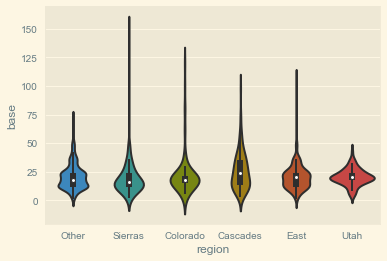

In [59]:
season_starts_df = long_series_df.pipe(closing_dt_finder).query('season_start==True')
sns.violinplot(data=season_starts_df, x='region', y='base');

In [64]:
long_series_df.head()

dayofyr  timestamp  base  station  snowfall  ski_yr   state region  \
13735       84 2010-11-16  72.0  Alyeska       NaN       0  alaska  Other   
13736       87 2010-11-19  65.0  Alyeska       NaN       0  alaska  Other   
13737       88 2010-11-20  64.0  Alyeska       NaN       0  alaska  Other   
13738       89 2010-11-21  63.0  Alyeska       NaN       0  alaska  Other   
13739       90 2010-11-22  62.0  Alyeska       NaN       0  alaska  Other   

       nan_locs  pseudo_ts  pseudo_ski_yr   diff  summer difference  \
13735     False 2002-11-18            8.0    NaT 60 days        NaT   
13736     False 2002-11-21            8.0 3 days 60 days     3 days   
13737     False 2002-11-22            8.0 1 days 60 days     1 days   
13738     False 2002-11-23            8.0 1 days 60 days     1 days   
13739     False 2002-11-24            8.0 1 days 60 days     1 days   

       season_end  season_start  
13735       False         False  
13736       False         False  
13737       False         False  
13738       False         False  
13739       False         False

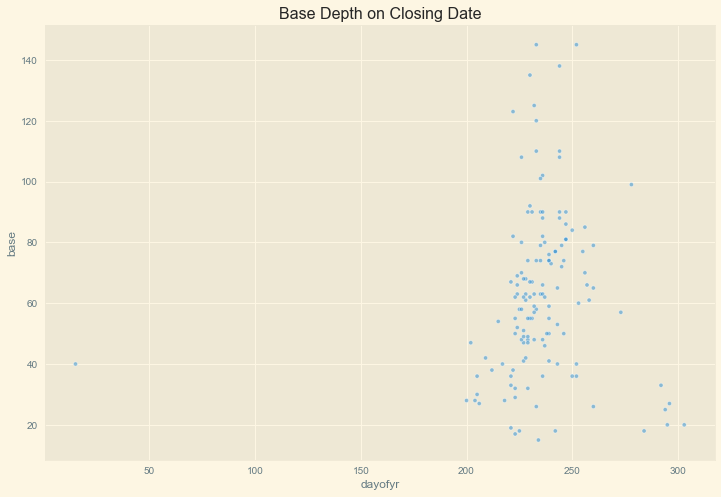

In [76]:
long_series_df.head()
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.scatterplot(data=long_series_df.query('season_end==True & region=="Colorado"'),
                x='dayofyr', y='base', 
                ax=ax, size=5, alpha=.5)
ax.set_title("Base Depth on Closing Date")
ax.get_legend().remove();

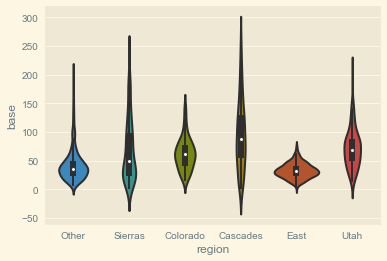

In [58]:
season_ends_df = long_series_df.pipe(closing_dt_finder).query('season_end==True')
sns.violinplot(data=season_ends_df, x='region', y='base');

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.
## ARIMA and extensions

There is clear seasonality so I will specify a Seasonal autoregressive integrated moving average model. I will start with the combined timeseries for the Colorado ski mountains.

In [ ]:
co_base_ts = (long_series_df
              .query('region=="Colorado"')
              [['base', 'pseudo_ts']]
              .sort_values(by='pseudo_ts')
             )

In [ ]:
def AC_plotter(df, lags):
    ac_plot = smg.tsaplots.plot_acf(x=df.base,
                                    ax=None, lags=lags, alpha=0.05, 
                                    use_vlines=True, unbiased=False,
                                    missing='conservative',
                                    title=f'Autocorrelation: lag of {lags}', 
                                    zero=True,
                                   )
    ac_plot;

In [ ]:
AC_plotter(co_base_ts, None)

In [ ]:
AC_plotter(co_base_ts, 1)

I will use differencing order of 1. There may be a trend do to sequence the mountains were concatenated in.

In [ ]:
co_base_ts_l1 = co_base_ts.diff(1)
AC_plotter(co_base_ts_l1, None)

In [ ]:
pac_plot = smg.tsaplots.plot_pacf(x=co_base_ts_l1.base, ax=None, lags=1,
                       alpha=0.05, method='ywunbiased', use_vlines=True, 
                       title='Partial Autocorrelation', zero=True, 
                       vlines_kwargs=None,)
pac_plot;

I will add one MA term because of the slight negative correlation on the differenced series on the first lag.

In [ ]:
co_base_ts_valuearr = co_base_ts.values[:,0].astype(np.single)

In [ ]:
 # (p, d, q) | (AR, diff, MA) ; need to slice values to get rid of ts data
arima_model = smt.arima.model.ARIMA(endog=co_base_ts_valuearr, order=(0, 1, 1))
arima_model_fit = arima_model.fit()

In [ ]:
arima_model_fit.summary()

In [ ]:
def resid_plotter(residuals):
    """plot residual errors"""
    residuals.plot(title="Residuals over Time")
    plt.show()
    residuals.plot(kind='kde', title="Residuals Distribution")
    plt.show()
    print(residuals.describe())
arima_resids = pd.DataFrame(arima_model_fit.resid)
resid_plotter(arima_resids)

there does not appear to be a trend. The errors are not exactly normal.

In [ ]:
def resid_qqer(residuals):
    plt.style.use('Solarize_Light2')
    size = residuals.shape[0]
    normal = np.random.normal(0, .1, size)
    
    #scale data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    residuals = scaler.fit_transform(residuals.sort_values(by=0))
    normal.sort()
    normal = normal.reshape(-1, 1)
    normal = scaler.fit_transform(normal)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.scatter(x=normal, y=residuals)
    #plt.plot(normal, residuals, "o")
    plt.xlabel('Normal Distribution')
    plt.ylabel('Distribution Residuals')
    plt.title('QQ Plot for Model Residuals')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
    #plt.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()
resid_qqer(residuals)

In [ ]:
def y_vs_yhat_plotter(fit_model, y):
    yhat = fit_model.predict()
    dataframe = pd.Dataframe()
    dataframe['y'] = y
    dataframe['yhat'] = yhat
    dataframe = dataframe.melt(value_vars=['y', 'yhat'])
    sns.lineplot(data=dataframe, y='value', )

this looks somewhat over-dispersed.

### SARIMA
There should not be any relationship between years (absent modeling climate-level dependencies e.g. El Niño cycles, so I will do a simple 1 years differencing.

In [ ]:
sarima_model = smt.arima.model.ARIMA(endog=co_base_ts_valuearr, order=(0, 1, 1),
                                    seasonal_order=(0, 1, 0, 365))
sarima_model_fit = sarima_model.fit()

ARIMAX using snowfall data with powder -> packed powder and melt inference

#### Other models
GARCH, Gaussian Process, hidden Markov

### Panel Models

# TF LSTM models
this is getting large. See the next notebook!